In [7]:
import os
import time
import functools
from typing import Callable, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import MyDataSet
from model.unet import TimeDependentScoreNet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Define SDE describing the data perturbation process

In [3]:
def marginal_prob_std(t: torch.Tensor, sigma: float) -> torch.Tensor:
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:    
      t: A vector of time steps.
      sigma: The $\sigma$ in our SDE.  
    
    Returns:
      The standard deviation.
    """    
    # t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t: torch.Tensor, sigma: float) -> torch.Tensor:
    """Compute the diffusion coefficient of our SDE.

    Args:
      t: A vector of time steps.
      sigma: The $\sigma$ in our SDE.
    
    Returns:
      The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)
    
sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [5]:
def loss_fn(model: nn.Module, x: torch.Tensor, marginal_prob_std: Callable, eps: float=1e-5)-> torch.Tensor:
    """The loss function for training score-based generative models.

    Args:
      model: A PyTorch model instance that represents a time-dependent score-based model.
      x: A mini-batch of training data.    
      marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
      eps: A tolerance value for numerical stability.
    """
    # Generate a random time vector with same length as mini batch, which represents the abritrary time points.
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

#### Training Function

In [33]:
def train(model,
          dataset,
          batch_size: int=64,
          n_epochs: int=50,
          device: str=device,
          verbose: bool=False,
          save: bool=True,
          save_path: str='../checkpoint/par_move.pth'):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    epoch_losses = []
    for epoch in range(n_epochs):
        time_start = time.time()
        for i, data in enumerate(dataloader):
            losses = []
            data = data.to(device).float()
            optimizer.zero_grad()
            loss = loss_fn(model, data, marginal_prob_std_fn)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        epoch_losses.append(np.mean(losses))
        print(f'Epoch [{epoch} / {n_epochs}] took {time.time() - time_start:.2f} seconds, loss: {epoch_losses[-1]:.4f}', flush=True)
        if save:
            torch.save(model.state_dict(), save_path)
    plt.plot(epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    if verbose:
        return epoch_losses

#### Prediction & Correction Sampling with Langevin Dynamics

In [76]:
signal_to_noise_ratio = 0.7

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model: nn.Module, 
               marginal_prob_std: Callable,
               diffusion_coeff: Callable,
               batch_size: int=64, 
               num_steps: int=num_steps, 
               snr: float=signal_to_noise_ratio,                
               device: str=device,
               eps: float=1e-3)-> torch.Tensor:
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
      score_model: A PyTorch model that represents the time-dependent score-based model.
      marginal_prob_std: A function that gives the standard deviation
        of the perturbation kernel.
      diffusion_coeff: A function that gives the diffusion coefficient 
        of the SDE.
      batch_size: The number of samplers to generate by calling this function once.
      num_steps: The number of sampling steps. 
        Equivalent to the number of discretized time steps.    
      device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
      eps: The smallest time step for numerical stability.
    
    Returns: 
      Samples.
    """
    # t=1 represents the final time, i.e. the pure Gaussian noise
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 2, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
      
      # The last step does not include any noise
    return x_mean

#### Visualization

In [53]:
def show_sample(dataset: torch.Tensor, idx: int, init_pos: np.array):
    fig, axes = plt.subplots(1, 4, dpi=100, figsize=(20, 5))
    displacement_x = dataset[idx][0, :, :].flatten()
    displacement_y = dataset[idx][1, :, :].flatten()
    axes[0].quiver(init_pos[:, 0], init_pos[:, 1], displacement_x, displacement_y, color='b', scale=100)
    axes[0].set_title("Displacement")

    p1 = axes[1].imshow(dataset[idx][0, :, :])
    axes[1].set_title("Displacement_x")
    fig.colorbar(p1, ax=axes[1])

    p2 = axes[2].imshow(dataset[idx][1, :, :])
    axes[2].set_title("Displacement_y")
    fig.colorbar(p2, ax=axes[2])

    axes[3].scatter(init_pos[:, 0], init_pos[:, 1], c='r', s=1, label='start points')
    axes[3].scatter(init_pos[:, 0]+displacement_x.numpy(), init_pos[:, 1]+displacement_y.numpy(), c='b', s=1, label='end points')
    axes[3].set_title("Trajectory")
    axes[3].legend()

def show_prediction(gen_sample: torch.Tensor, init_pos: np.array, orientation: torch.Tensor, dataset: torch.Tensor, tick_range: list=[-4, 8]):
    fig, axes = plt.subplots(4, 5, dpi=100, figsize=(25, 20))
    idx = np.random.randint(len(dataset))
    axes[1][0].scatter(init_pos[:, 0], init_pos[:, 1], c='r', s=1, label='start points')
    axes[1][0].scatter(init_pos[:, 0]+orientation[0].flatten().detach().numpy(), init_pos[:, 1]+orientation[1].flatten().detach().numpy(), c='b', s=1, label='end points')
    axes[1][0].set_title("Ground Truth (without noise)")
    axes[1][0].legend()

    axes[2][0].scatter(init_pos[:, 0], init_pos[:, 1], c='r', s=1, label='start points')
    axes[2][0].scatter(init_pos[:, 0]+dataset[idx][0, :, :].flatten().detach().numpy(), init_pos[:, 1]+dataset[idx][1, :, :].flatten().detach().numpy(), c='b', s=1, label='end points')
    axes[2][0].set_title("Ground Truth (with noise)")
    axes[2][0].legend()

    for i_sample in range(4):
        for j_sample in range(1, 5):
            idx_sample = i_sample * 4 + j_sample - 1
            displacement_x = gen_sample[idx_sample, 0, :, :].flatten().cpu().numpy()
            displacement_y = gen_sample[idx_sample, 1, :, :].flatten().cpu().numpy()
            axes[i_sample][j_sample].scatter(init_pos[:, 0], init_pos[:, 1], c='r', s=1)
            axes[i_sample][j_sample].scatter(init_pos[:, 0]+displacement_x, init_pos[:, 1]+displacement_y, c='b', s=1)
            axes[i_sample][j_sample].set_xlim(tick_range[0], tick_range[1])
            axes[i_sample][j_sample].set_ylim(tick_range[0], tick_range[1])
    
    axes[0][0].set_axis_off()
    axes[3][0].set_axis_off()

### Learning the particles' movement

In [13]:
init_pos = []
x = np.linspace(-4, 4, 28)
y = np.linspace(-4, 4, 28)
for i in x:
    for j in y:
        init_pos.append([i, j])
init_pos = np.array(init_pos)

#### Diagonal movement

In [10]:
orientation_ur = torch.ones(2, 28, 28) * 3
dataset1 = MyDataSet(num_samples=10000, orientation=orientation_ur, noise=0.1)
model1 = TimeDependentScoreNet(input_channel=2, marginal_prob_std=marginal_prob_std_fn).to(device)

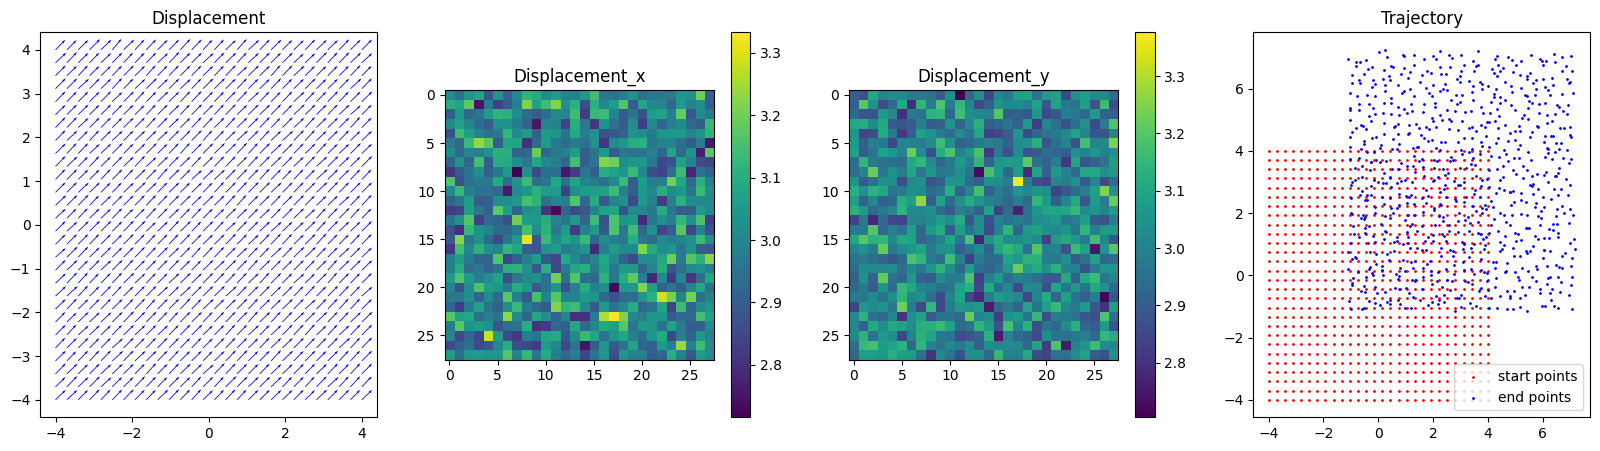

In [14]:
show_sample(dataset=dataset1, idx=3, init_pos=init_pos)

Epoch [0 / 50] took 4.04 seconds, loss: 281.9107
Epoch [1 / 50] took 3.63 seconds, loss: 218.4669
Epoch [2 / 50] took 3.54 seconds, loss: 65.6236
Epoch [3 / 50] took 3.53 seconds, loss: 39.8590
Epoch [4 / 50] took 3.54 seconds, loss: 146.2231
Epoch [5 / 50] took 3.51 seconds, loss: 18.4978
Epoch [6 / 50] took 3.55 seconds, loss: 30.6319
Epoch [7 / 50] took 3.53 seconds, loss: 121.9603
Epoch [8 / 50] took 3.54 seconds, loss: 88.6070
Epoch [9 / 50] took 3.53 seconds, loss: 23.5924
Epoch [10 / 50] took 3.54 seconds, loss: 14.2530
Epoch [11 / 50] took 3.54 seconds, loss: 84.3219
Epoch [12 / 50] took 3.55 seconds, loss: 55.1192
Epoch [13 / 50] took 3.53 seconds, loss: 18.7448
Epoch [14 / 50] took 3.56 seconds, loss: 27.0713
Epoch [15 / 50] took 3.59 seconds, loss: 39.7070
Epoch [16 / 50] took 3.56 seconds, loss: 68.6659
Epoch [17 / 50] took 3.57 seconds, loss: 49.2989
Epoch [18 / 50] took 3.52 seconds, loss: 104.9500
Epoch [19 / 50] took 3.55 seconds, loss: 158.3088
Epoch [20 / 50] took 3.5

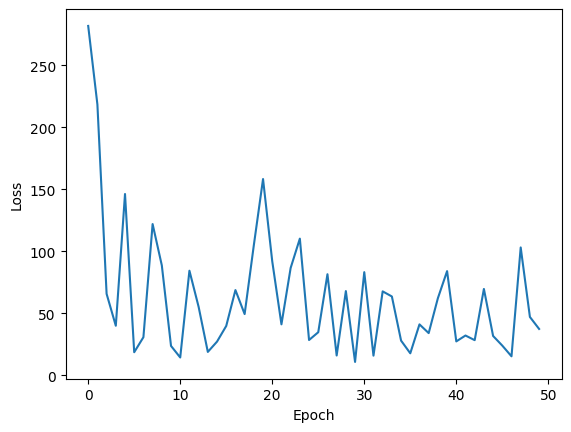

In [17]:
train(model=model1, dataset=dataset1, batch_size=128, n_epochs=50)

In [20]:
sample_batch_size = 16 #@param {'type':'integer'}
sampler = pc_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples1 = sampler(model1, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

  0%|          | 0/500 [00:00<?, ?it/s]/home/gefan/tmp/ipykernel_696730/2787335585.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 500/500 [00:04<00:00, 106.92it/s]


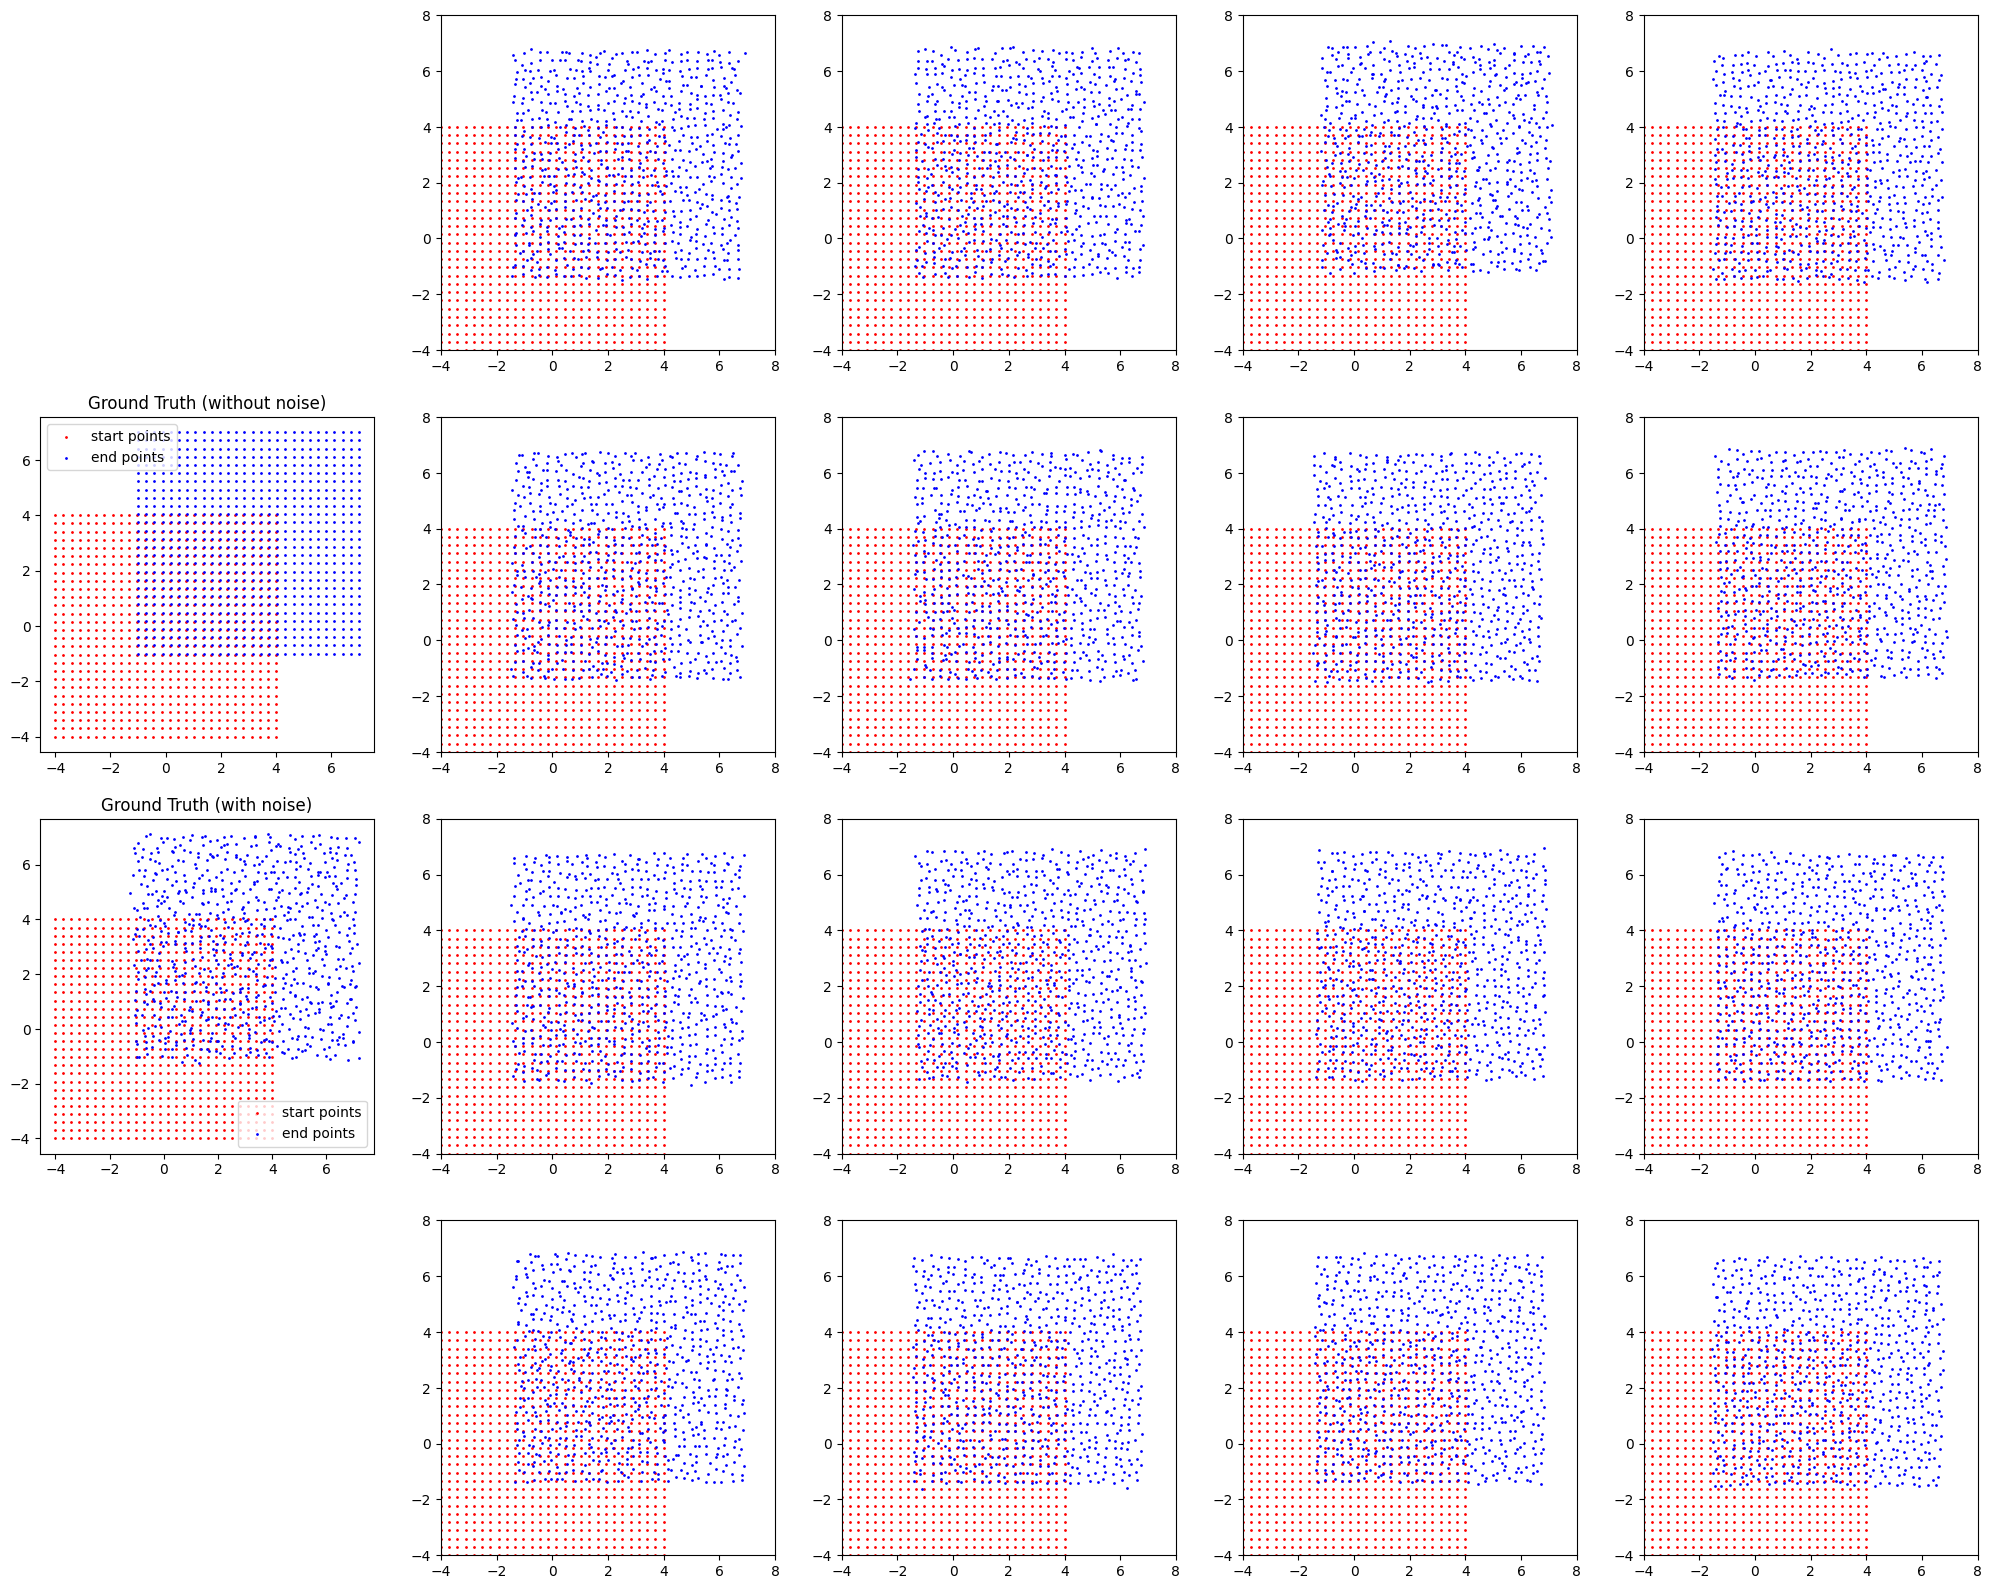

In [27]:
show_prediction(gen_sample=samples1, init_pos=init_pos, orientation=orientation_ur, dataset=dataset1)

#### Gaussian Movement

In [28]:
# define a 2d gaussian which takes in a 2d tensor
def gaussian2d(x, y, mu_x, mu_y, sigma_x, sigma_y, rho, scale):
    x = x - mu_x
    y = y - mu_y
    z = x ** 2 / sigma_x ** 2 + y ** 2 / sigma_y ** 2 - 2 * rho * x * y / (sigma_x * sigma_y)
    return scale * torch.exp(-z / (2 * (1 - rho ** 2)))

In [29]:
orientation_gau = gaussian2d(torch.tensor(init_pos[:, 0]), torch.tensor(init_pos[:, 1]), 0, 0, 3, 3, 0, 7)
orientation_gau = orientation_gau.reshape(1, 28, 28)
orientation_gau = orientation_gau.expand(2, -1, -1)

In [31]:
dataset2 = MyDataSet(num_samples=10000, orientation=orientation_gau, noise=0.1)
model2 = TimeDependentScoreNet(input_channel=2, marginal_prob_std=marginal_prob_std_fn).to(device)

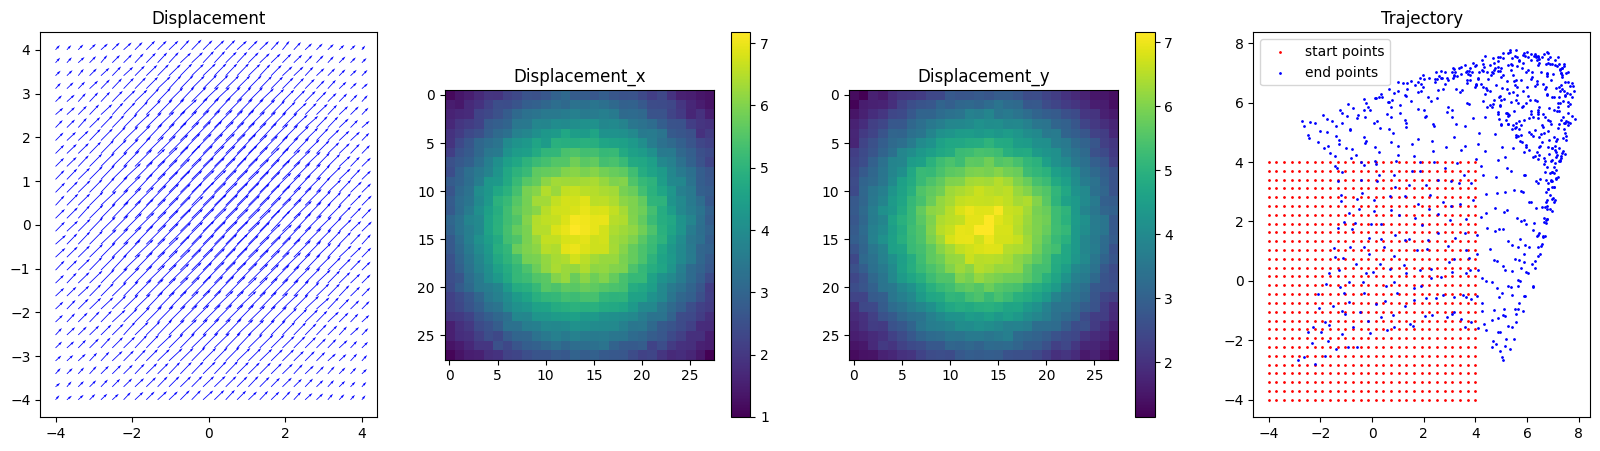

In [32]:
show_sample(dataset=dataset2, idx=6, init_pos=init_pos)

Epoch [0 / 50] took 3.37 seconds, loss: 251.8155
Epoch [1 / 50] took 3.54 seconds, loss: 191.2520
Epoch [2 / 50] took 3.60 seconds, loss: 88.9464
Epoch [3 / 50] took 3.55 seconds, loss: 95.2758
Epoch [4 / 50] took 3.58 seconds, loss: 66.5164
Epoch [5 / 50] took 3.58 seconds, loss: 57.9428
Epoch [6 / 50] took 3.57 seconds, loss: 63.2261
Epoch [7 / 50] took 3.60 seconds, loss: 27.5994
Epoch [8 / 50] took 3.57 seconds, loss: 85.2173
Epoch [9 / 50] took 3.59 seconds, loss: 49.6121
Epoch [10 / 50] took 3.57 seconds, loss: 65.5168
Epoch [11 / 50] took 3.60 seconds, loss: 20.1722
Epoch [12 / 50] took 3.60 seconds, loss: 35.4941
Epoch [13 / 50] took 3.57 seconds, loss: 105.3220
Epoch [14 / 50] took 3.57 seconds, loss: 27.9191
Epoch [15 / 50] took 3.54 seconds, loss: 90.5245
Epoch [16 / 50] took 3.58 seconds, loss: 54.3290
Epoch [17 / 50] took 3.63 seconds, loss: 104.1723
Epoch [18 / 50] took 3.61 seconds, loss: 20.0535
Epoch [19 / 50] took 3.55 seconds, loss: 15.8070
Epoch [20 / 50] took 3.57 

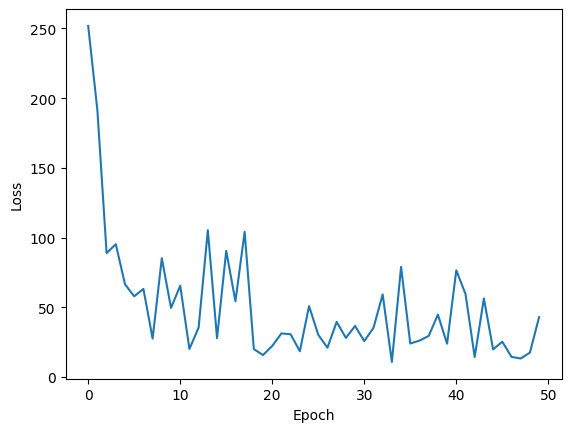

In [37]:
train(model=model2, dataset=dataset2, batch_size=128, n_epochs=50, save_path='./checkpoint/model_gau.pth')

In [38]:
samples2 = sampler(model2, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

  0%|          | 0/500 [00:00<?, ?it/s]/home/gefan/tmp/ipykernel_696730/2787335585.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 500/500 [00:04<00:00, 108.10it/s]


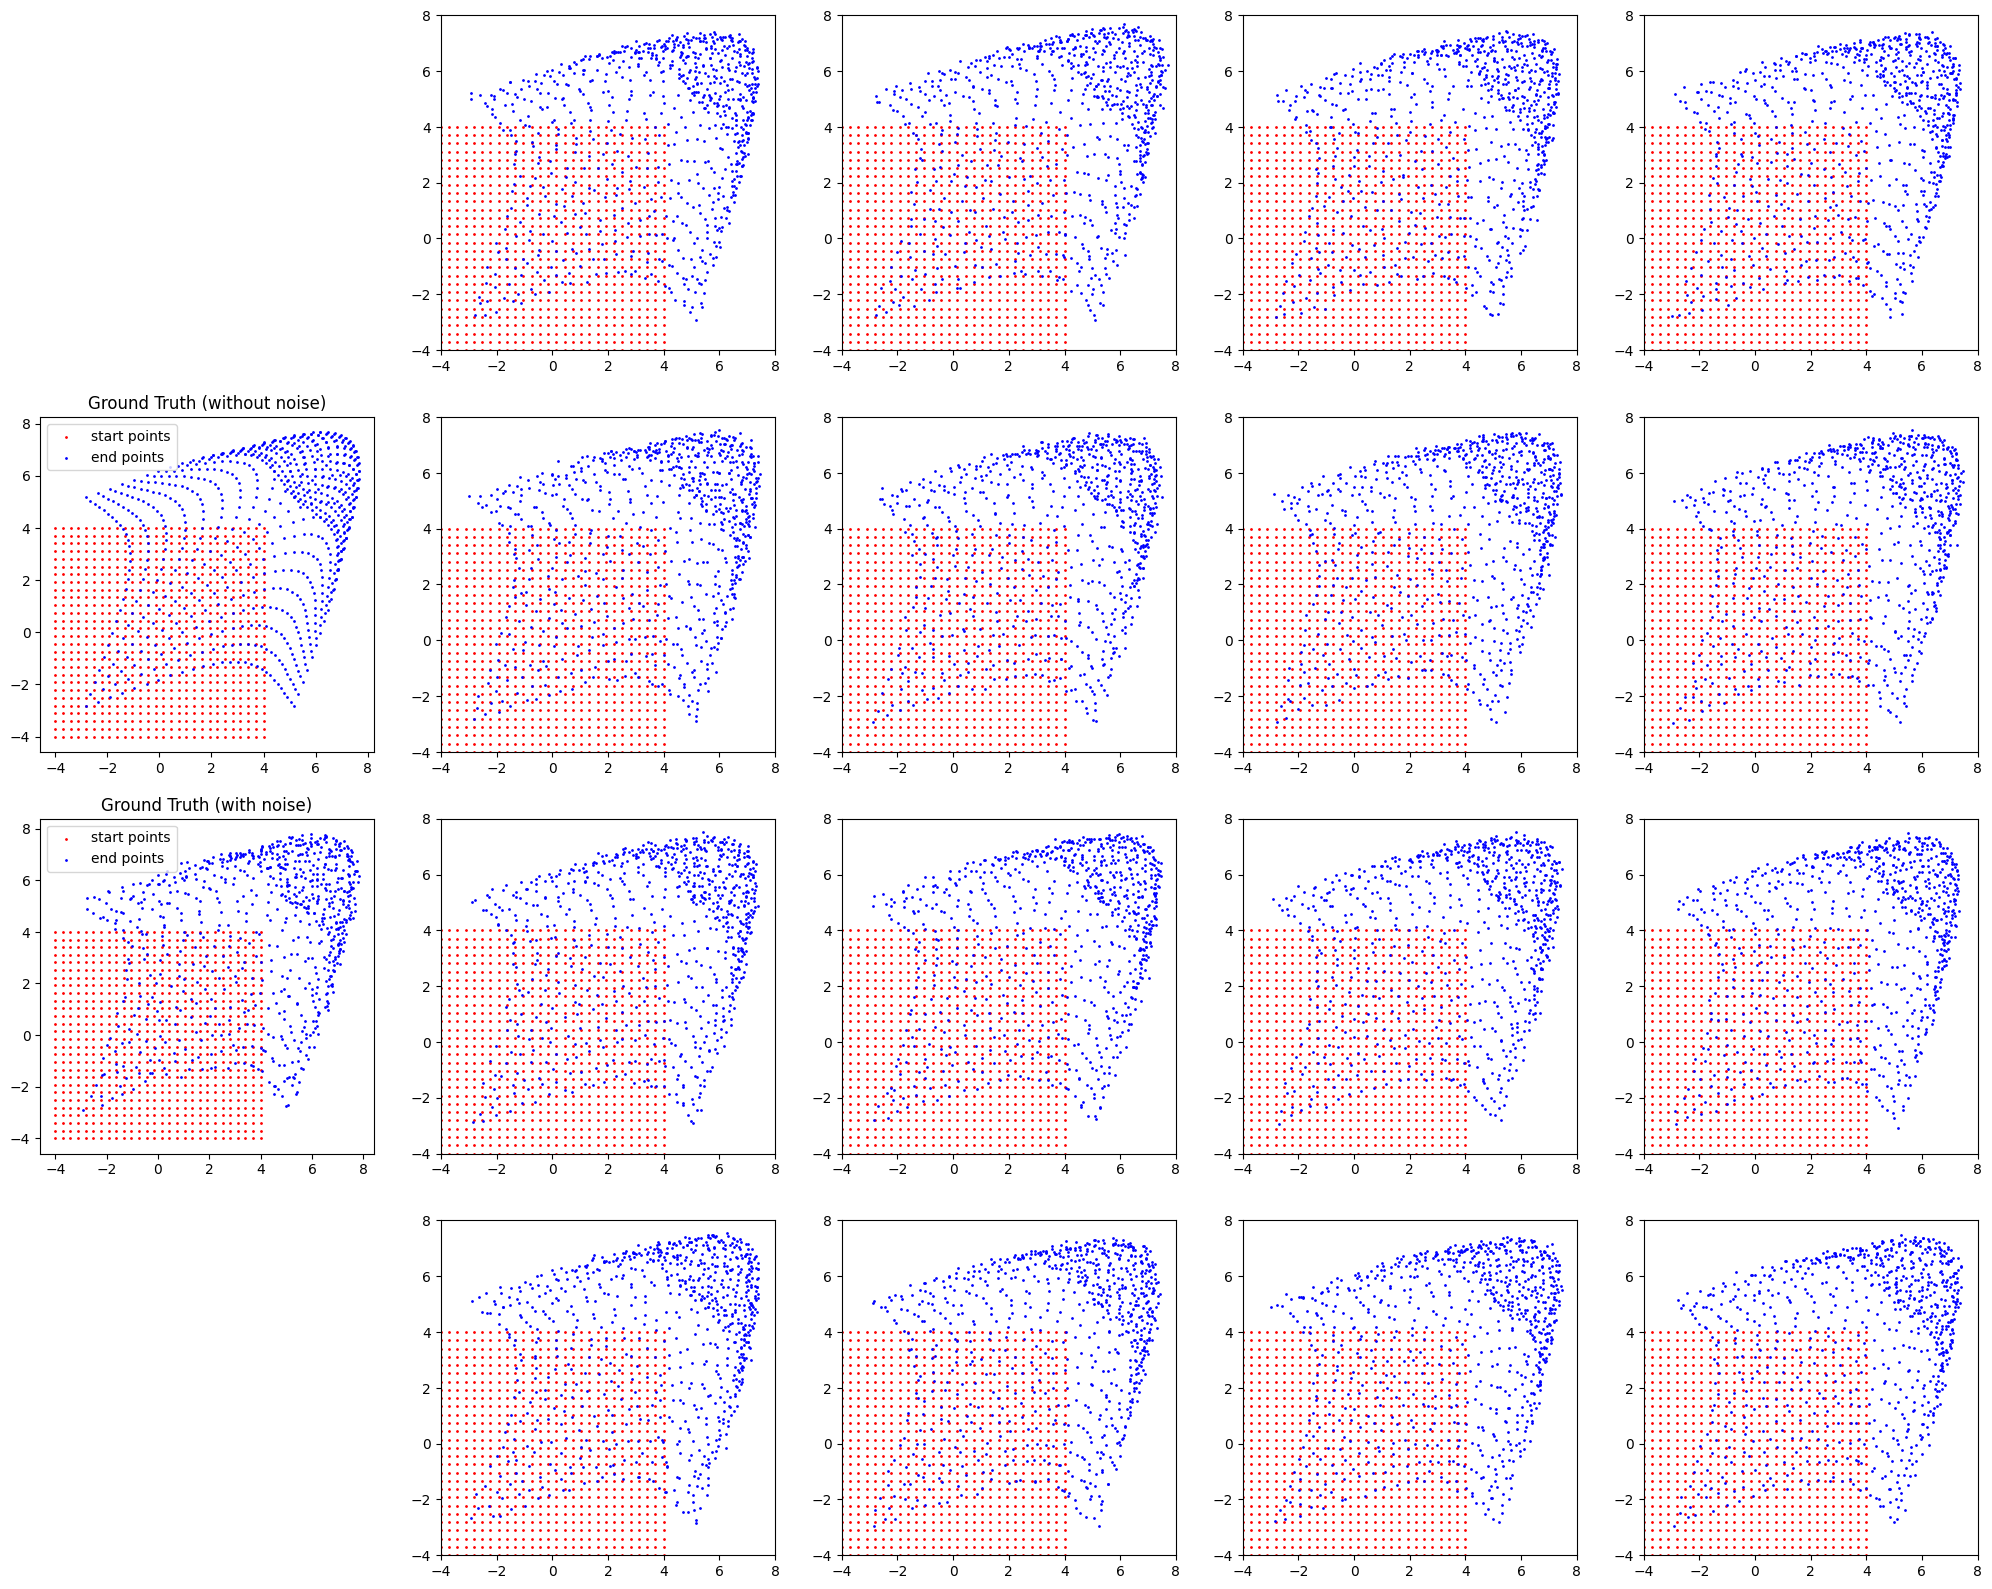

In [39]:
show_prediction(gen_sample=samples2, init_pos=init_pos, orientation=orientation_gau, dataset=dataset2)

#### Seperation movement

In [40]:
orientation_sep = torch.ones(2, 28, 28) * 3
orientation_sep[0, :14, :14] *= -1
orientation_sep[1, 14:, 14:] *= -1
orientation_sep[0, 14:, :14] *= -1
orientation_sep[1, 14:, :14] *= -1

In [41]:
dataset3 = MyDataSet(num_samples=10000, orientation=orientation_sep, noise=0.1)
model3 = TimeDependentScoreNet(input_channel=2, marginal_prob_std=marginal_prob_std_fn).to(device)

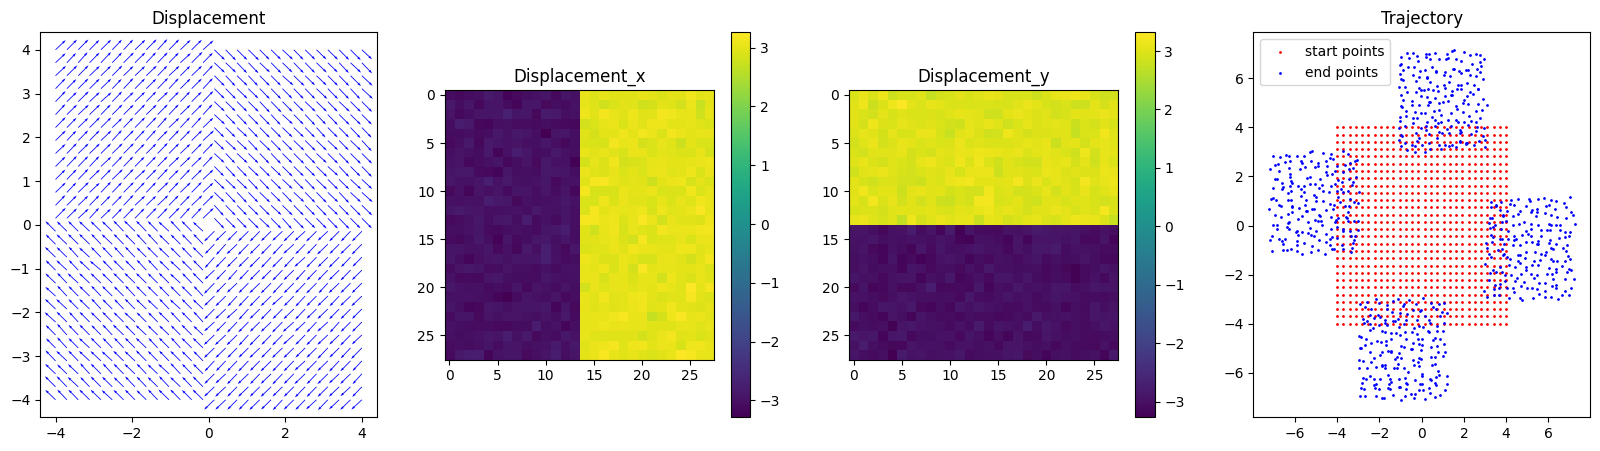

In [42]:
show_sample(dataset=dataset3, idx=5, init_pos=init_pos)

Epoch [0 / 50] took 3.56 seconds, loss: 414.7190
Epoch [1 / 50] took 3.55 seconds, loss: 228.2099
Epoch [2 / 50] took 3.54 seconds, loss: 191.4321
Epoch [3 / 50] took 3.54 seconds, loss: 178.7596
Epoch [4 / 50] took 3.55 seconds, loss: 85.7471
Epoch [5 / 50] took 3.54 seconds, loss: 84.4277
Epoch [6 / 50] took 3.53 seconds, loss: 49.7680
Epoch [7 / 50] took 3.55 seconds, loss: 20.7290
Epoch [8 / 50] took 3.55 seconds, loss: 43.1550
Epoch [9 / 50] took 3.28 seconds, loss: 157.4087
Epoch [10 / 50] took 3.52 seconds, loss: 56.1033
Epoch [11 / 50] took 3.56 seconds, loss: 31.7657
Epoch [12 / 50] took 3.56 seconds, loss: 31.5328
Epoch [13 / 50] took 3.61 seconds, loss: 43.2528
Epoch [14 / 50] took 3.58 seconds, loss: 60.1603
Epoch [15 / 50] took 3.57 seconds, loss: 133.6422
Epoch [16 / 50] took 3.61 seconds, loss: 30.5626
Epoch [17 / 50] took 3.57 seconds, loss: 22.2890
Epoch [18 / 50] took 3.63 seconds, loss: 16.7428
Epoch [19 / 50] took 3.55 seconds, loss: 58.4576
Epoch [20 / 50] took 3.5

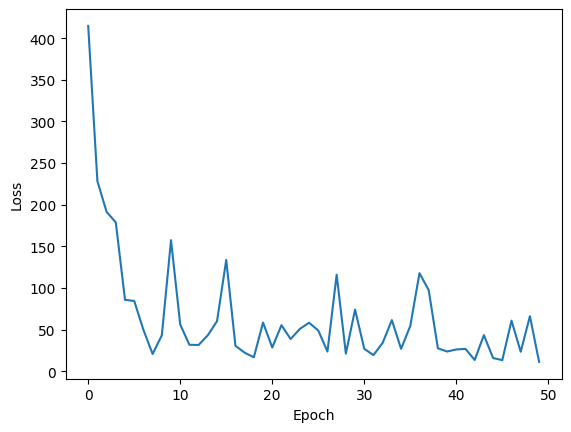

In [43]:
train(model=model3, dataset=dataset3, batch_size=128, n_epochs=50, save_path='./checkpoint/model_seg.pth')

In [44]:
samples3 = sampler(model3, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

  0%|          | 0/500 [00:00<?, ?it/s]/home/gefan/tmp/ipykernel_696730/2787335585.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 500/500 [00:04<00:00, 106.53it/s]


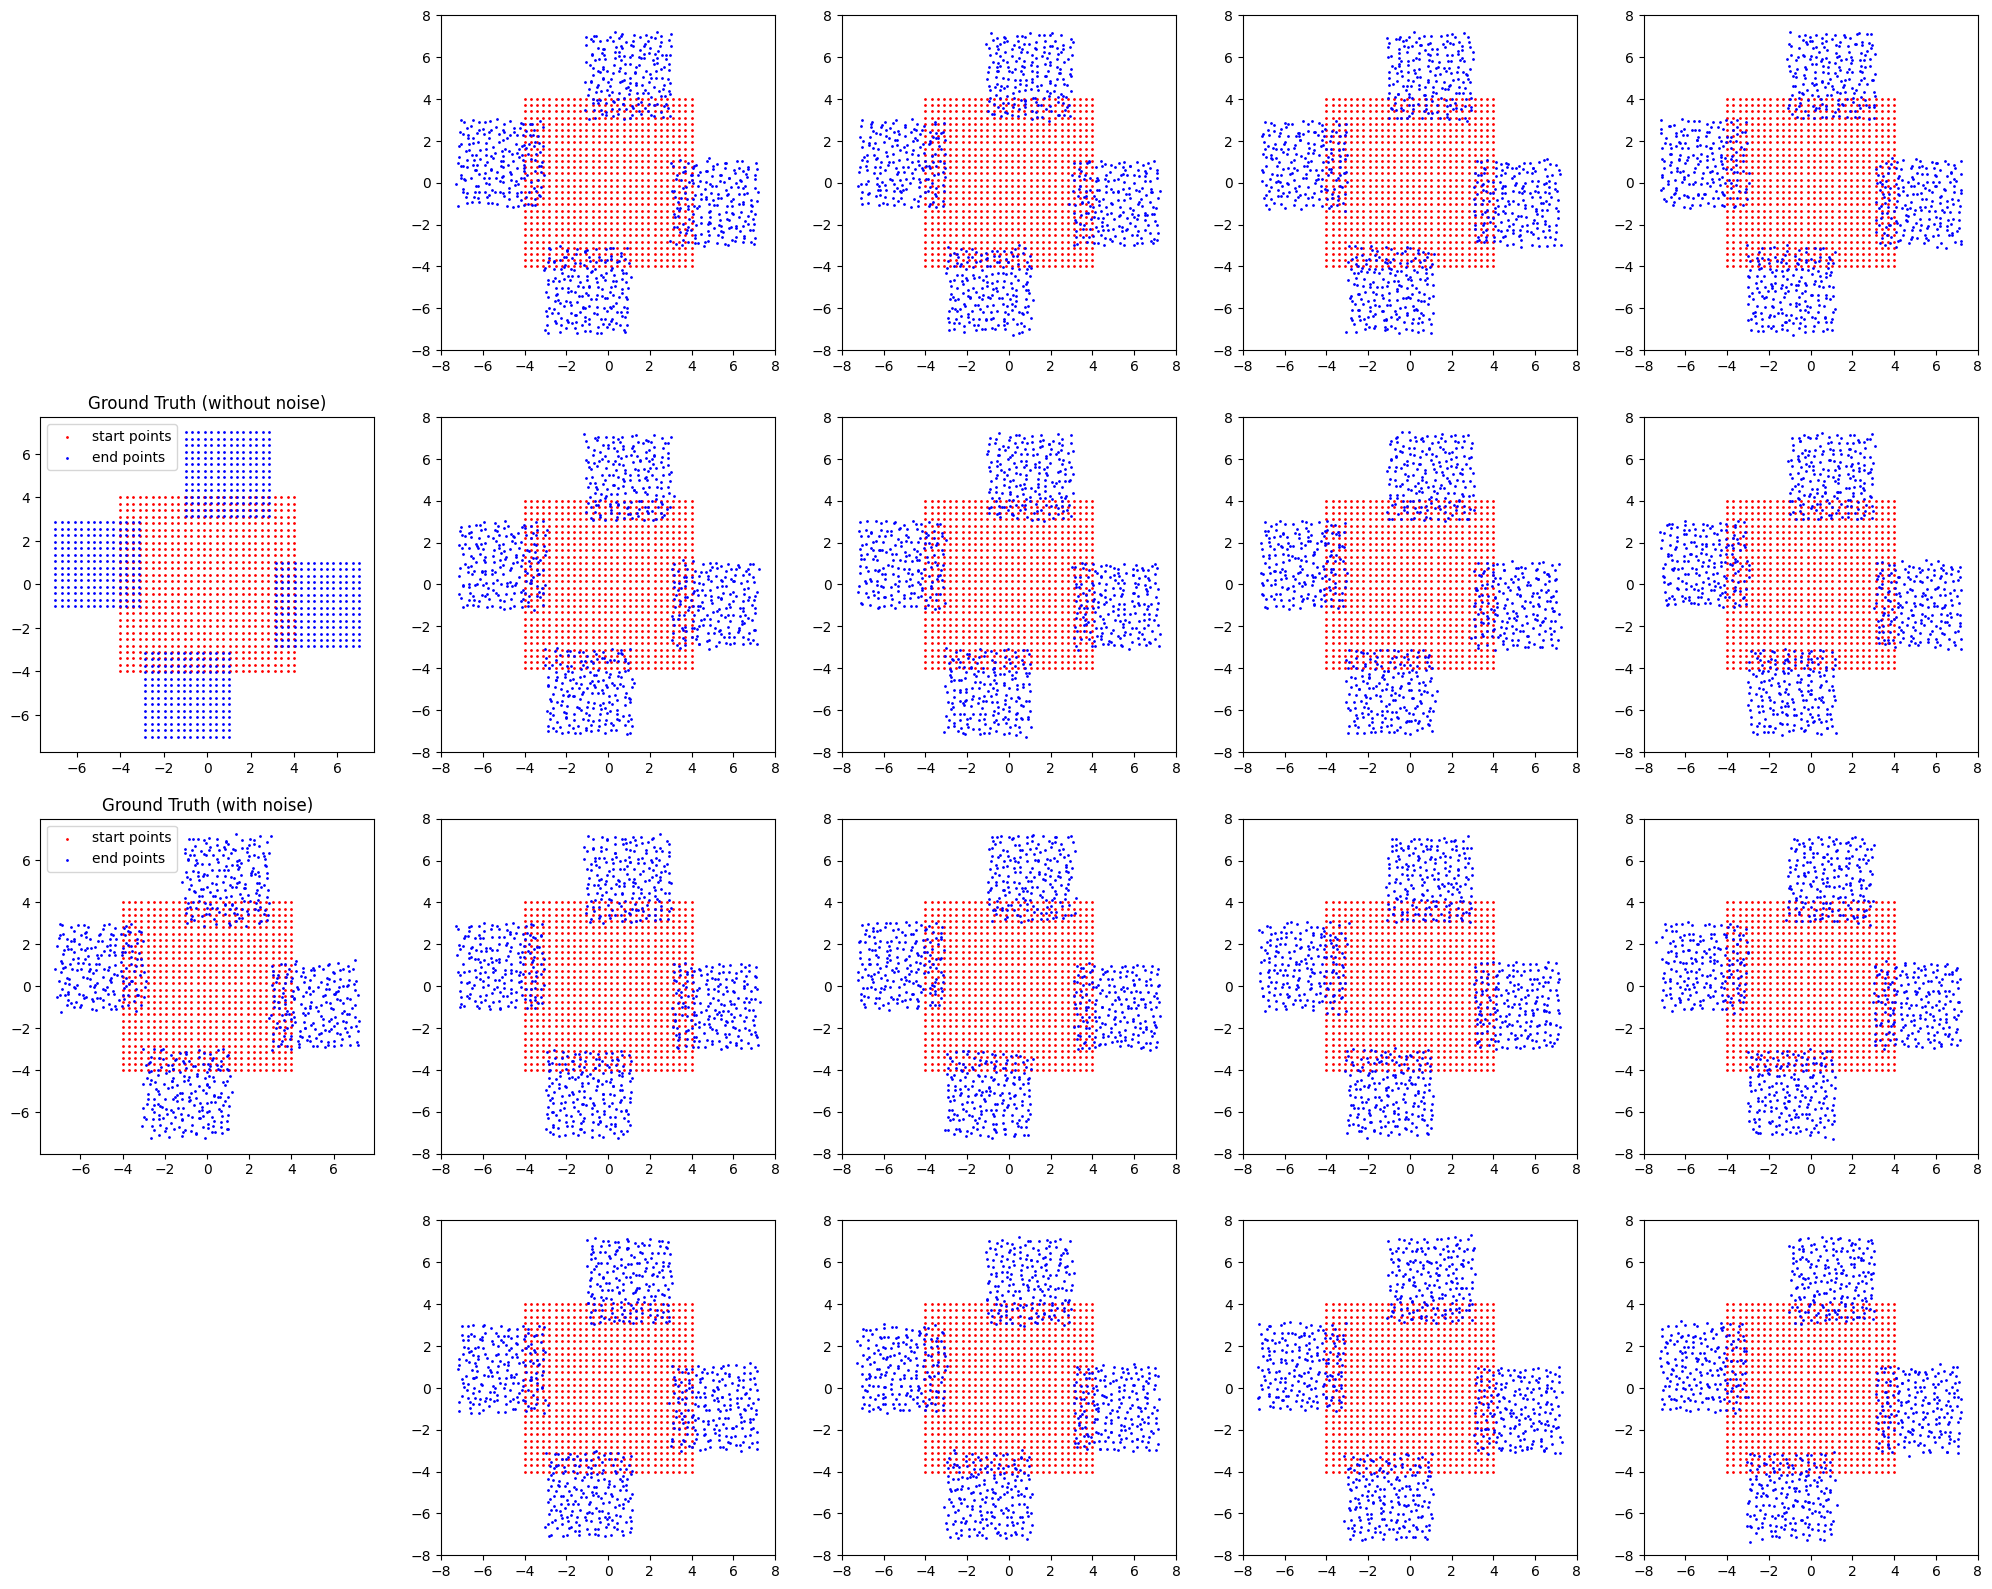

In [54]:
show_prediction(gen_sample=samples3, init_pos=init_pos, orientation=orientation_sep, dataset=dataset3, tick_range=[-8, 8])

### Implementation on Real Simulation

#### with data augmentation

In [55]:
import h5py

In [56]:
def read_h5py(filename):
    f = h5py.File(filename, 'r')
    dataset = f['dataset'][:]
    f.close()
    return dataset

In [57]:
aug_data = read_h5py('../data/augmented_data')

In [58]:
aug_dataset = torch.from_numpy(aug_data).float()
aug_dataset = aug_dataset.permute(0, 3, 1, 2)

#### New initial position, just for matching the simulation

In [59]:
space = 0.1
radius = 0.5
dx = 2 * radius + space
dy = 2 * radius + space
init_pos = []
for i in range(28):
    for j in range(28):
        init_pos.append([i * dx - (28-1)/2 * dx , j * dy - (28-1)/2 * dy])
init_pos = np.array(init_pos)

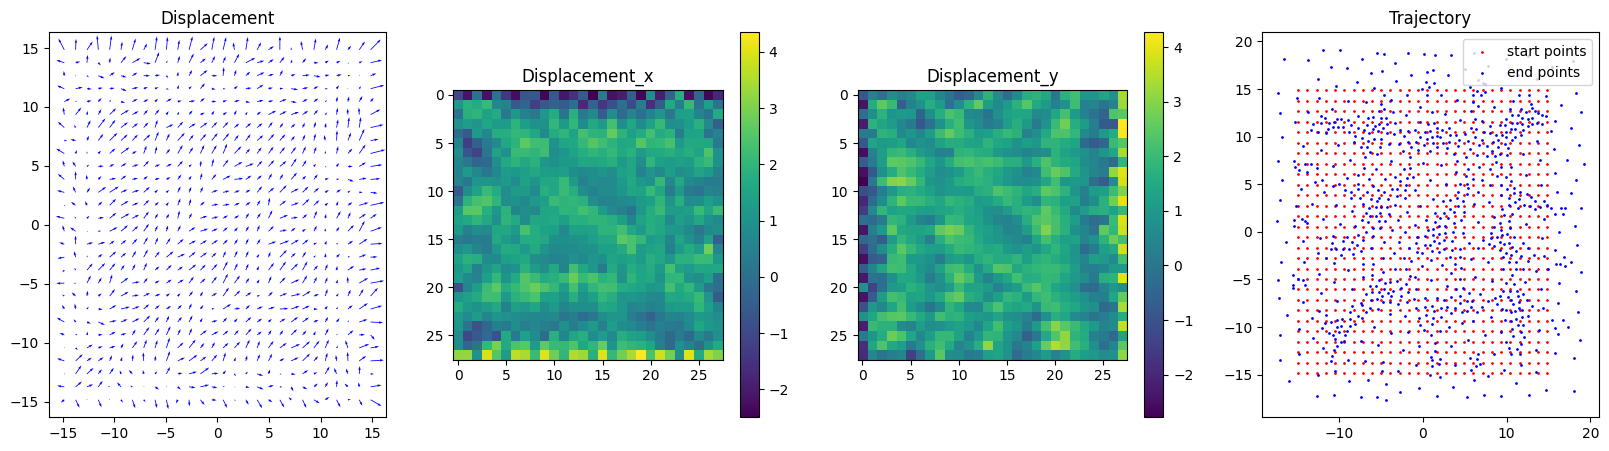

In [61]:
show_sample(dataset=aug_dataset, idx=5, init_pos=init_pos)

In [62]:
model4 = TimeDependentScoreNet(input_channel=2, marginal_prob_std=marginal_prob_std_fn).to(device)

Epoch [0 / 50] took 3.56 seconds, loss: 489.5248
Epoch [1 / 50] took 3.58 seconds, loss: 426.5443
Epoch [2 / 50] took 3.56 seconds, loss: 388.1148
Epoch [3 / 50] took 3.58 seconds, loss: 420.6091
Epoch [4 / 50] took 3.62 seconds, loss: 197.1413
Epoch [5 / 50] took 3.57 seconds, loss: 377.5382
Epoch [6 / 50] took 3.63 seconds, loss: 316.0038
Epoch [7 / 50] took 3.56 seconds, loss: 254.4144
Epoch [8 / 50] took 3.58 seconds, loss: 245.0572
Epoch [9 / 50] took 3.58 seconds, loss: 353.0091
Epoch [10 / 50] took 3.56 seconds, loss: 210.4435
Epoch [11 / 50] took 3.64 seconds, loss: 304.8763
Epoch [12 / 50] took 3.64 seconds, loss: 269.9120
Epoch [13 / 50] took 3.56 seconds, loss: 133.1404
Epoch [14 / 50] took 3.55 seconds, loss: 272.4697
Epoch [15 / 50] took 3.65 seconds, loss: 109.5167
Epoch [16 / 50] took 3.58 seconds, loss: 195.8215
Epoch [17 / 50] took 3.60 seconds, loss: 226.4856
Epoch [18 / 50] took 3.55 seconds, loss: 113.9626
Epoch [19 / 50] took 3.53 seconds, loss: 177.6560
Epoch [20 

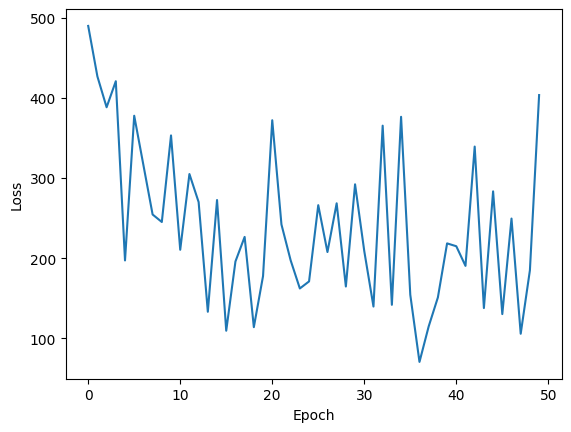

In [63]:
train(model=model4, dataset=aug_dataset, batch_size=128, n_epochs=50, save_path='./checkpoint/model_aug.pth')

In [64]:
samples4 = sampler(model4, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

  0%|          | 0/500 [00:00<?, ?it/s]/home/gefan/tmp/ipykernel_696730/2787335585.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 500/500 [00:04<00:00, 108.71it/s]


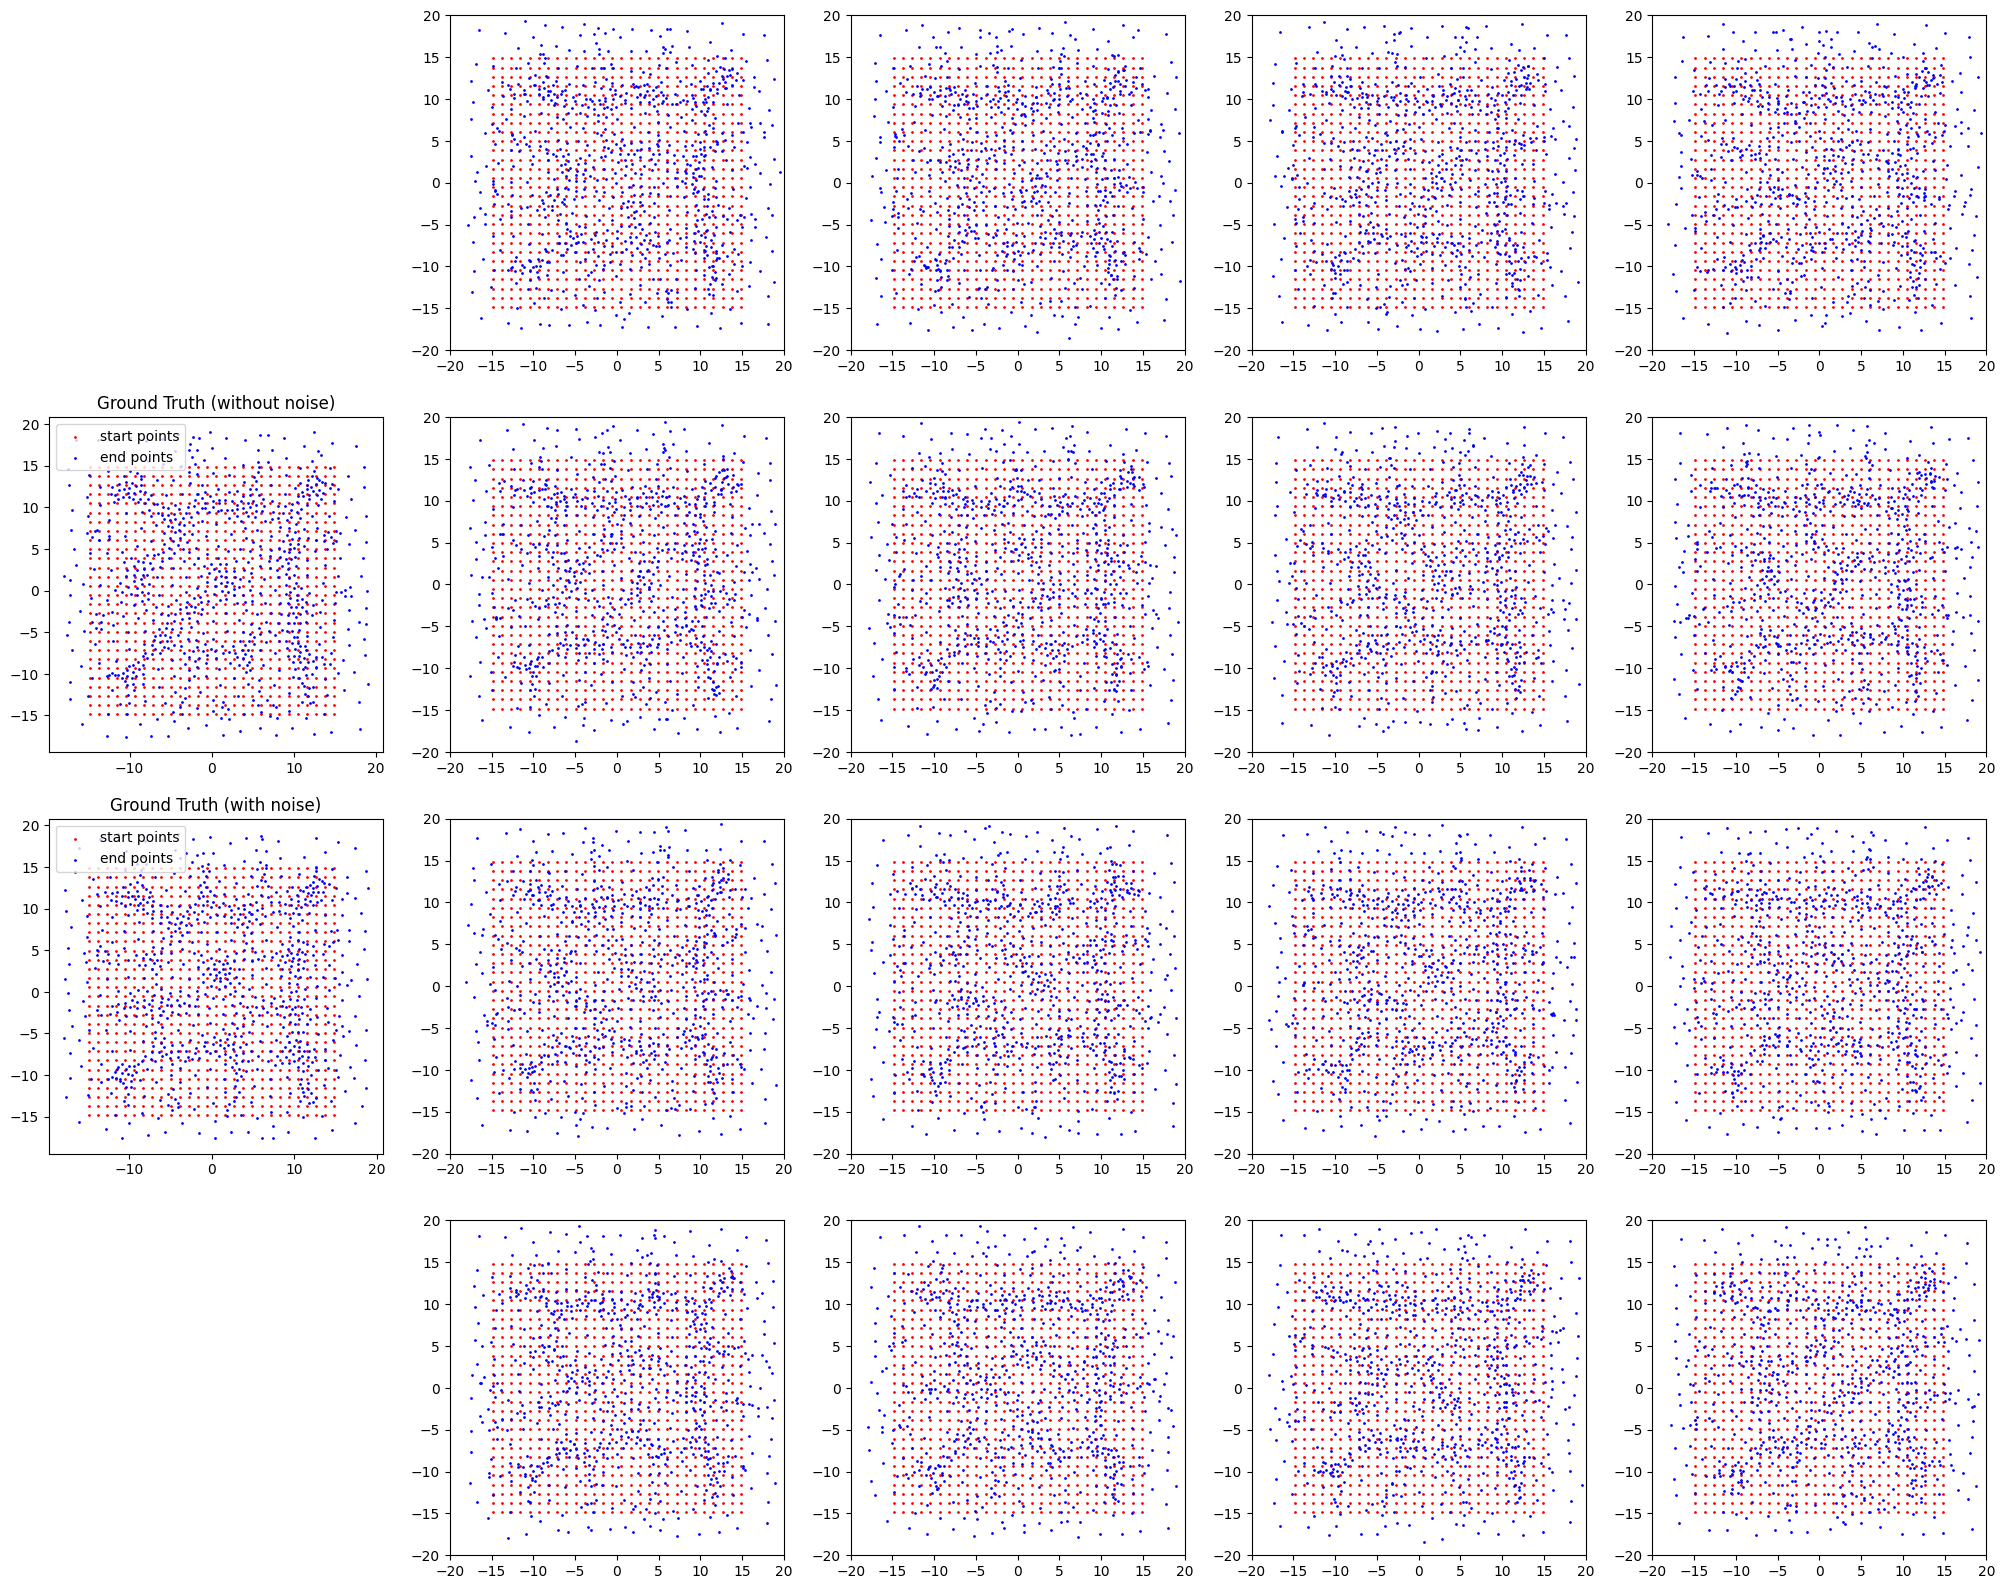

In [66]:
show_prediction(gen_sample=samples4, init_pos=init_pos, orientation=aug_dataset[3], dataset=aug_dataset, tick_range=[-20, 20])

#### Implement on original data

In [67]:
ori_data = read_h5py('../data/original_data')
ori_dataset = torch.from_numpy(ori_data).float()
ori_dataset = ori_dataset.permute(0, 3, 1, 2)

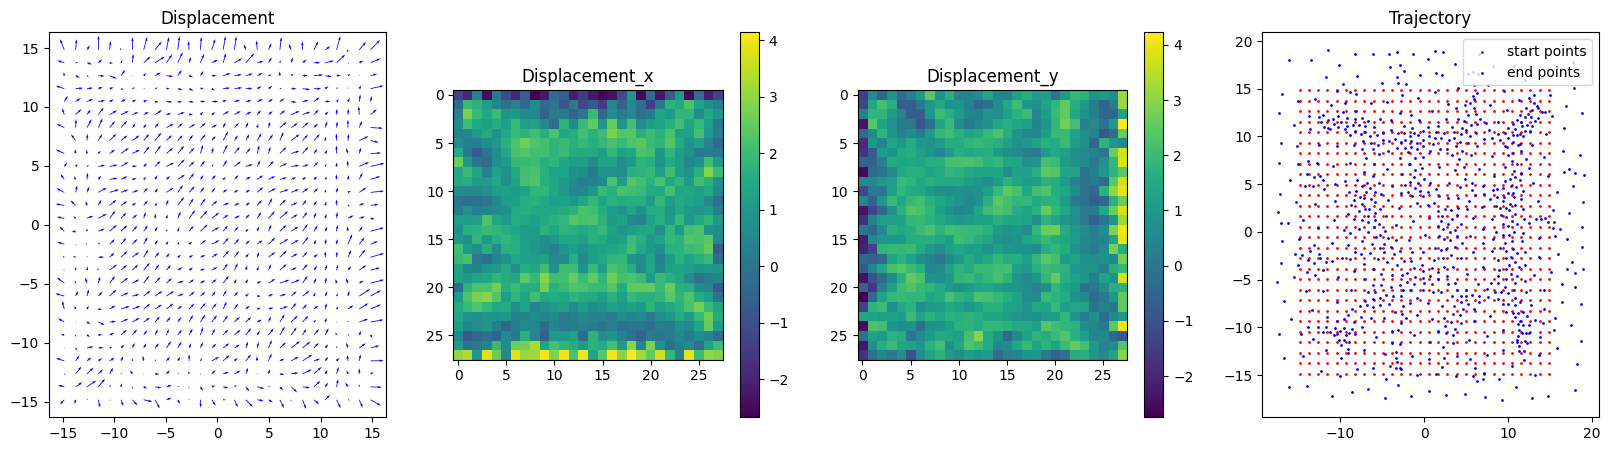

In [68]:
show_sample(dataset=ori_dataset, idx=5000, init_pos=init_pos)

In [69]:
model4 = TimeDependentScoreNet(input_channel=2, marginal_prob_std=marginal_prob_std_fn).to(device)

Epoch [0 / 50] took 7.22 seconds, loss: 255.7370
Epoch [1 / 50] took 7.16 seconds, loss: 170.6487
Epoch [2 / 50] took 7.15 seconds, loss: 159.1880
Epoch [3 / 50] took 7.16 seconds, loss: 314.0830
Epoch [4 / 50] took 7.17 seconds, loss: 256.8158
Epoch [5 / 50] took 7.23 seconds, loss: 218.5829
Epoch [6 / 50] took 7.22 seconds, loss: 256.0207
Epoch [7 / 50] took 7.16 seconds, loss: 311.5251
Epoch [8 / 50] took 7.25 seconds, loss: 192.3901
Epoch [9 / 50] took 7.19 seconds, loss: 149.2109
Epoch [10 / 50] took 7.18 seconds, loss: 163.3804
Epoch [11 / 50] took 7.22 seconds, loss: 254.5386
Epoch [12 / 50] took 7.20 seconds, loss: 259.5471
Epoch [13 / 50] took 7.23 seconds, loss: 234.3395
Epoch [14 / 50] took 7.25 seconds, loss: 81.4585
Epoch [15 / 50] took 7.27 seconds, loss: 158.9413
Epoch [16 / 50] took 7.25 seconds, loss: 189.8004
Epoch [17 / 50] took 7.23 seconds, loss: 316.0295
Epoch [18 / 50] took 7.27 seconds, loss: 272.9299
Epoch [19 / 50] took 7.17 seconds, loss: 210.0134
Epoch [20 /

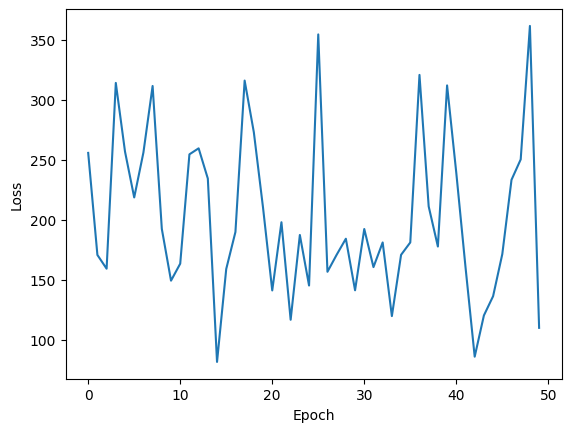

In [70]:
train(model=model4, dataset=ori_dataset, batch_size=32, n_epochs=50, save_path='./checkpoint/model_real.pth')

In [79]:
samples5 = sampler(score_model=model4,
                   marginal_prob_std=marginal_prob_std_fn,
                   diffusion_coeff=diffusion_coeff_fn, 
                   batch_size=sample_batch_size,
                   num_steps=1000, 
                   device=device)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/gefan/tmp/ipykernel_696730/2787335585.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 1000/1000 [00:09<00:00, 106.62it/s]


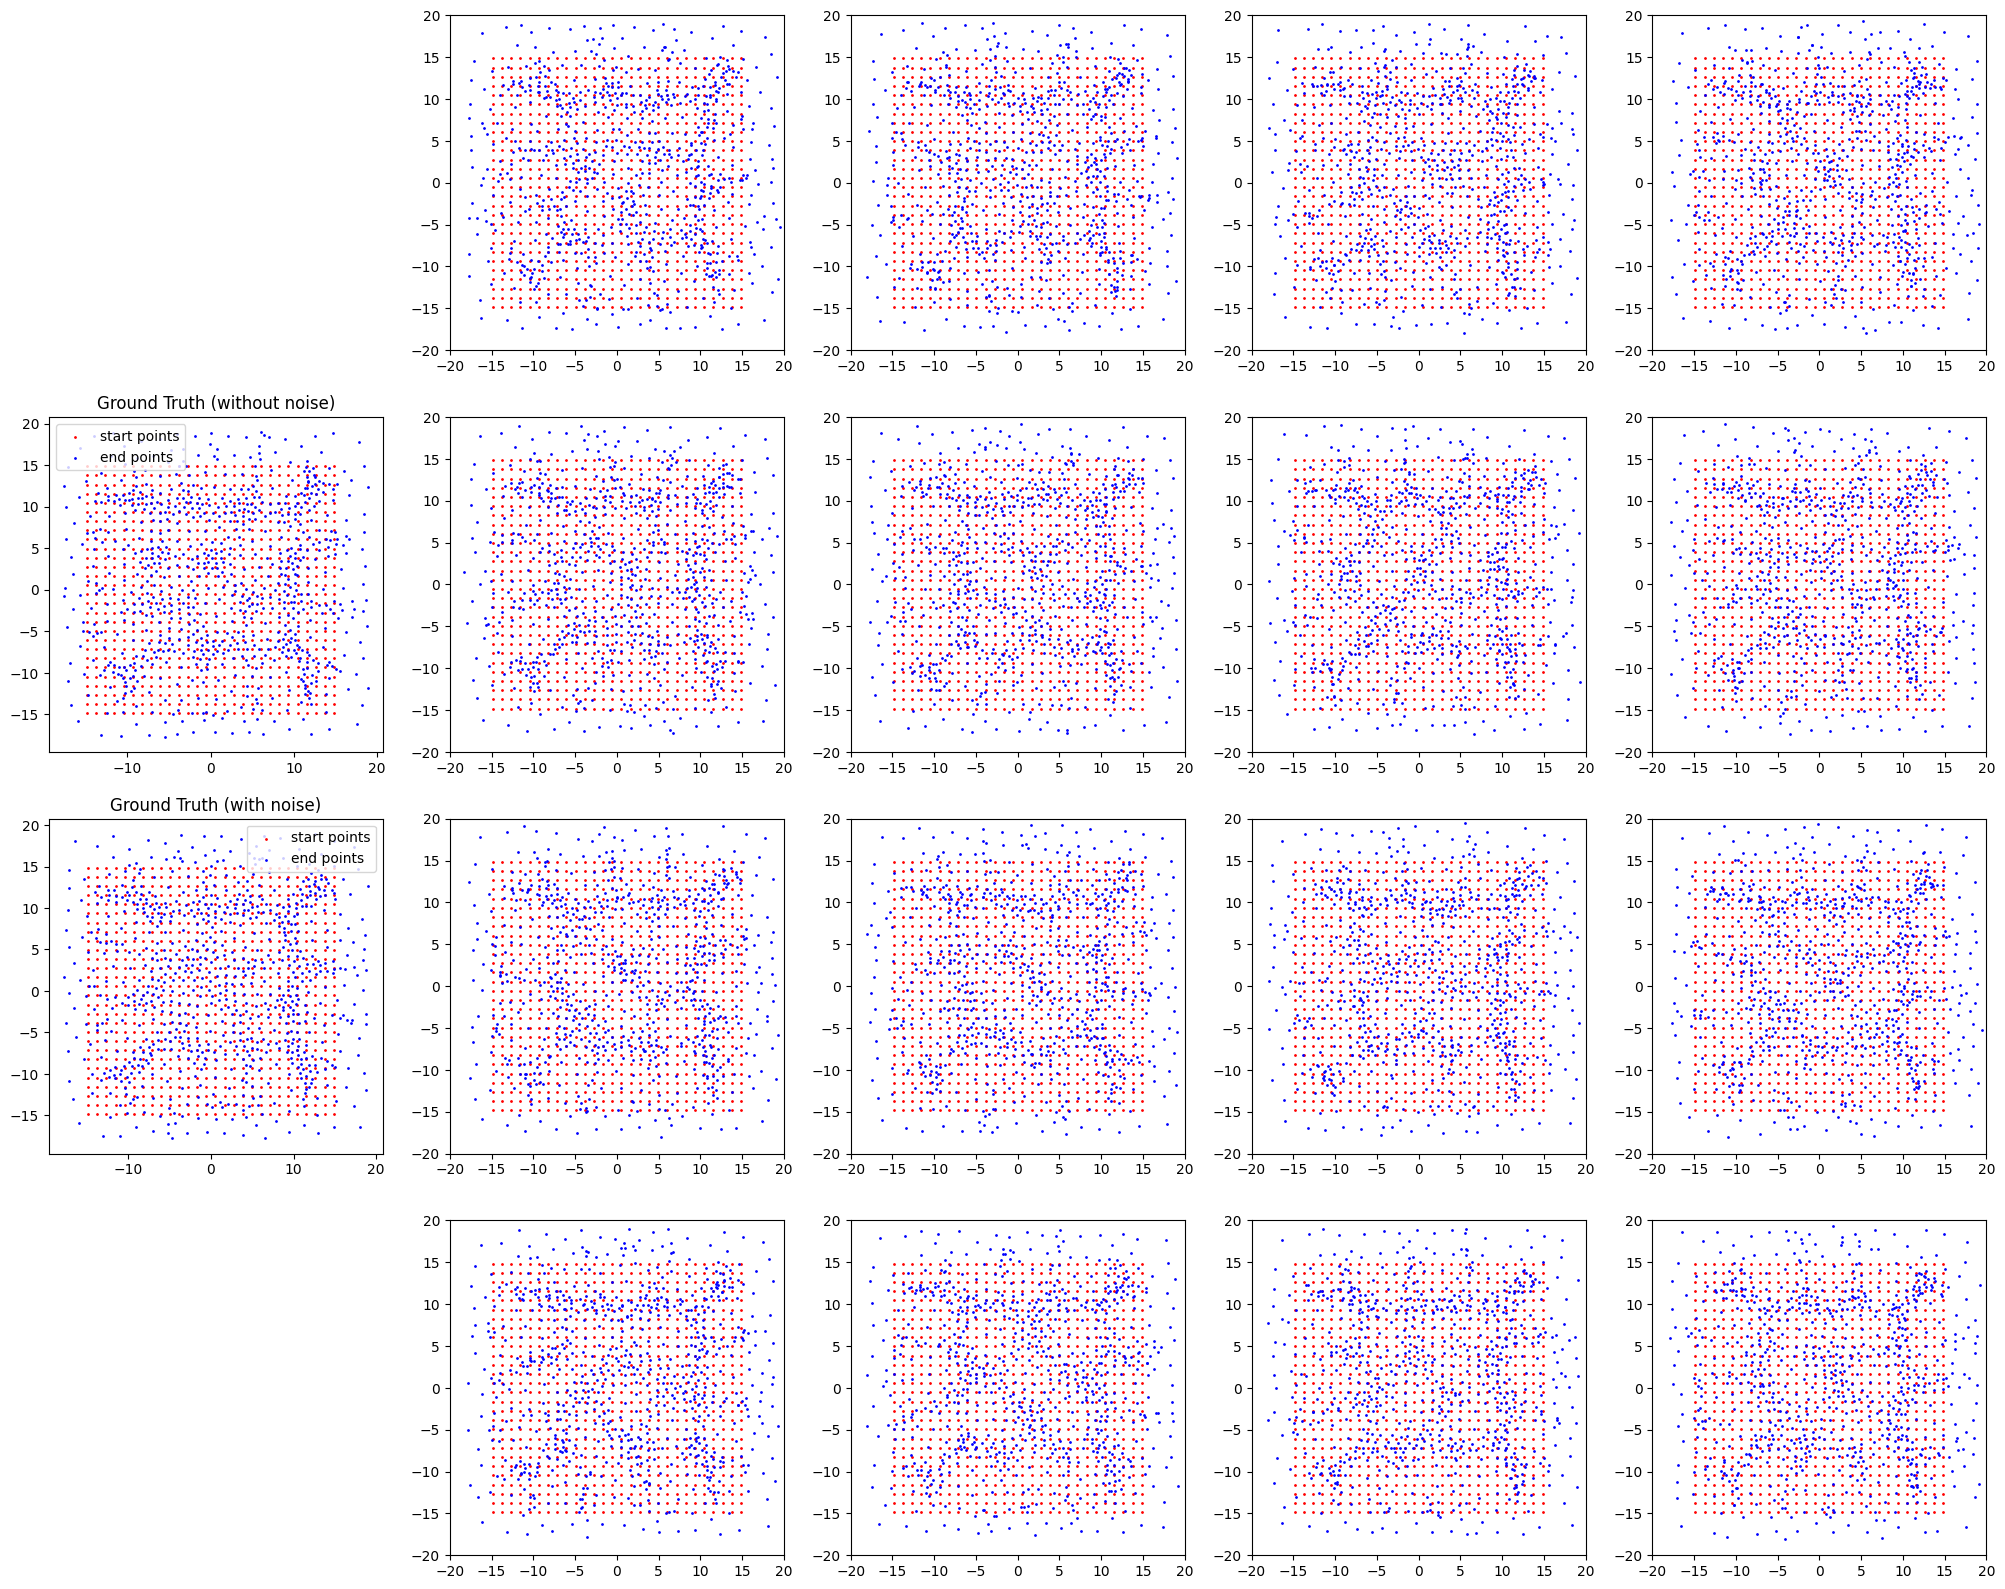

In [80]:
show_prediction(gen_sample=samples5, init_pos=init_pos, orientation=ori_dataset[3], dataset=ori_dataset, tick_range=[-20, 20])